## Correlating Gini and M20 Coefficients.
This Notebook takes the results from the HEC of the Gini and M20 calculations and looks for their correlations in the different samples.

### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.nddata import Cutout2D

from IPython.display import clear_output

### Looking at Merger Sample

In [3]:
data_folder = 'C:/Users/oryan/Documents/mergers_in_desi/results'
folder = 'E:/GZ-DESI/data'
df_int = pd.read_parquet(f'{folder}/2023-03-15-cats/definitive-merged-interesting-params.parquet', engine = 'pyarrow')[['id_str', 'redshift']]

In [4]:
df_gini = pd.read_csv(f'{data_folder}/ginis-mergers-90.csv', index_col = 0)
df_m20 = pd.read_csv(f'{data_folder}/m20s-merger-90.csv', index_col = 0)

In [5]:
df_m20.columns

Index(['id_str', 'ra', 'dec', 'est_petro_th50', 'hec_path', 'm20'], dtype='object')

In [6]:
df_m20_red = (
    df_m20[['id_str', 'm20']]
)

In [7]:
df_merge = df_gini.merge(df_m20_red, on = 'id_str', how = 'left')

In [8]:
del df_gini, df_m20, df_m20_red

In [9]:
df_sele = df_merge.query('gini_r != "partial-overlap" and gini_r != "empty-image" and gini_r != "corrupted" and gini_r != "Failed"')

In [10]:
df_tmp = (
    df_sele
    .assign(gini_r_int = df_sele.gini_r.apply(lambda x: float(x)))
)

In [11]:
df_float = (
    df_tmp
    .assign(m20_int = df_tmp.m20.apply(lambda x: float(x)))
)

In [12]:
norm_line = [
    [-0.6, 0.45],
    [-3,0.71]
]
norm_arr = np.asarray(norm_line)

In [13]:
norm_arr[:,0]

array([-0.6, -3. ])

In [17]:
df_merge = df_float.merge(df_int, on = 'id_str', how = 'left').dropna()

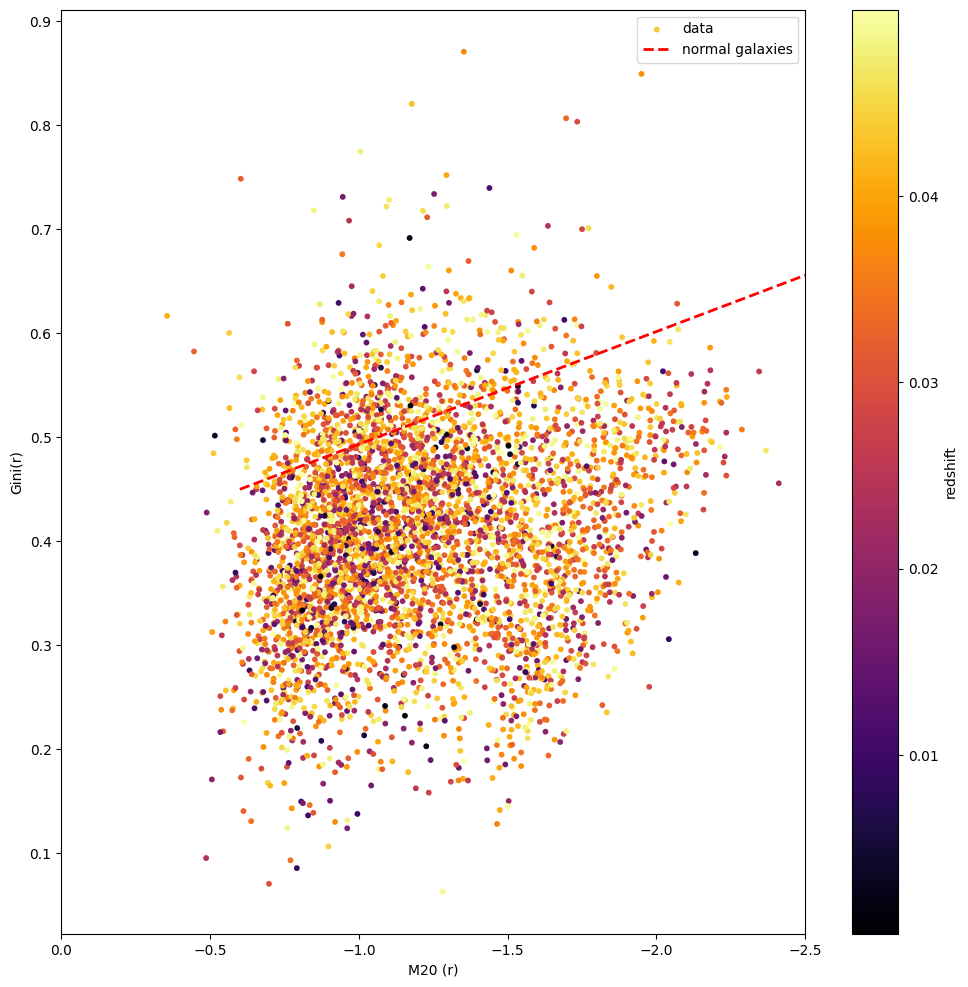

In [48]:
fig, ax1 = plt.subplots(nrows = 1)
df_merge.query('redshift < 0.05').plot.scatter(
    x = 'm20_int',
    y = 'gini_r_int',
    c = 'redshift',
    colormap = 'inferno',
    colorbar=True,
    figsize = (12,12),
    s = 10,
    # alpha = 0.01,
    xlim = [0, -2.5],
    ylabel = 'Gini(r)',
    xlabel = 'M20 (r)',
    ax = ax1,
    label = 'data'
)

ax1.plot(norm_arr[:,0], norm_arr[:,1], color = 'red', linestyle='dashed', linewidth = 2.0, label = 'normal galaxies')
plt.legend()

plt.show()

### Making Digitised Plot

In [53]:
def show_thumbnails(df, num_bins=50):
    _, hx, hy = np.histogram2d(list(df.gini_r_int), list(df.m20_int), bins=[num_bins, num_bins])
    
    hx_indices = np.digitize(list(df.gini_r_int), hx)
    hy_indices = np.digitize(list(df.m20_int), hy)
    h_indices = np.stack([hx_indices, hy_indices], axis = 1)
    
    
    image_map = {}
    for image_loc, indices in zip(df['local_paths'], h_indices):
        image_map[tuple(indices)] = image_loc
    
    fig,axes = plt.subplots(ncols=num_bins+1, nrows = num_bins+1, figsize=(35,35))
    
    for row in axes:
        for ax in row:
            ax.axis('off')
    
    for indices, image_loc in image_map.items():
        ax = axes[indices[0] - 1, indices[1]-1]
        
        data = fits.getdata(image_loc)
        header = fits.getheader(image_loc)
        
        tmp = df.query('local_paths == @image_loc')
        ra = tmp.ra.iloc[0]
        dec = tmp.dec.iloc[0]
        
        cutout = data[1,:,:]
        
#         w = WCS(header, naxis = 2)

#         size = u.Quantity((10*petro_50, 10*petro_50), u.arcsec)
#         coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'icrs')
#         cutout = Cutout2D(data, coord, size, wcs = w, mode='strict')
        
        ax.imshow(np.log10(cutout))
        clear_output(wait = True)
        ax.axis('off')
        
        del data, header, tmp
    
    fig.tight_layout(pad = 0.0)
    fig.text(0.01, 0.5, 'Gini (r)', ha='center', va='center', rotation='vertical', fontsize = 24)
    fig.text(0.5, 0.01, 'M20 (r)', ha='center', va='center', fontsize = 24)
    # fig.savefig('C:/Users/oryan/Documents/mergers_in_desi/images/digitized-gini-m20-dist.jpeg')

In [54]:
df_digi = (
    df_float
    .drop(columns = 'hec_path')
    .assign(local_paths = df_float.id_str.apply(lambda x: f'E:/GZ-DESI/images/mergers/{x}-cutout.fits'))
    .dropna()
    .query('m20_int > -1e20')
)

Wall time: 55 s


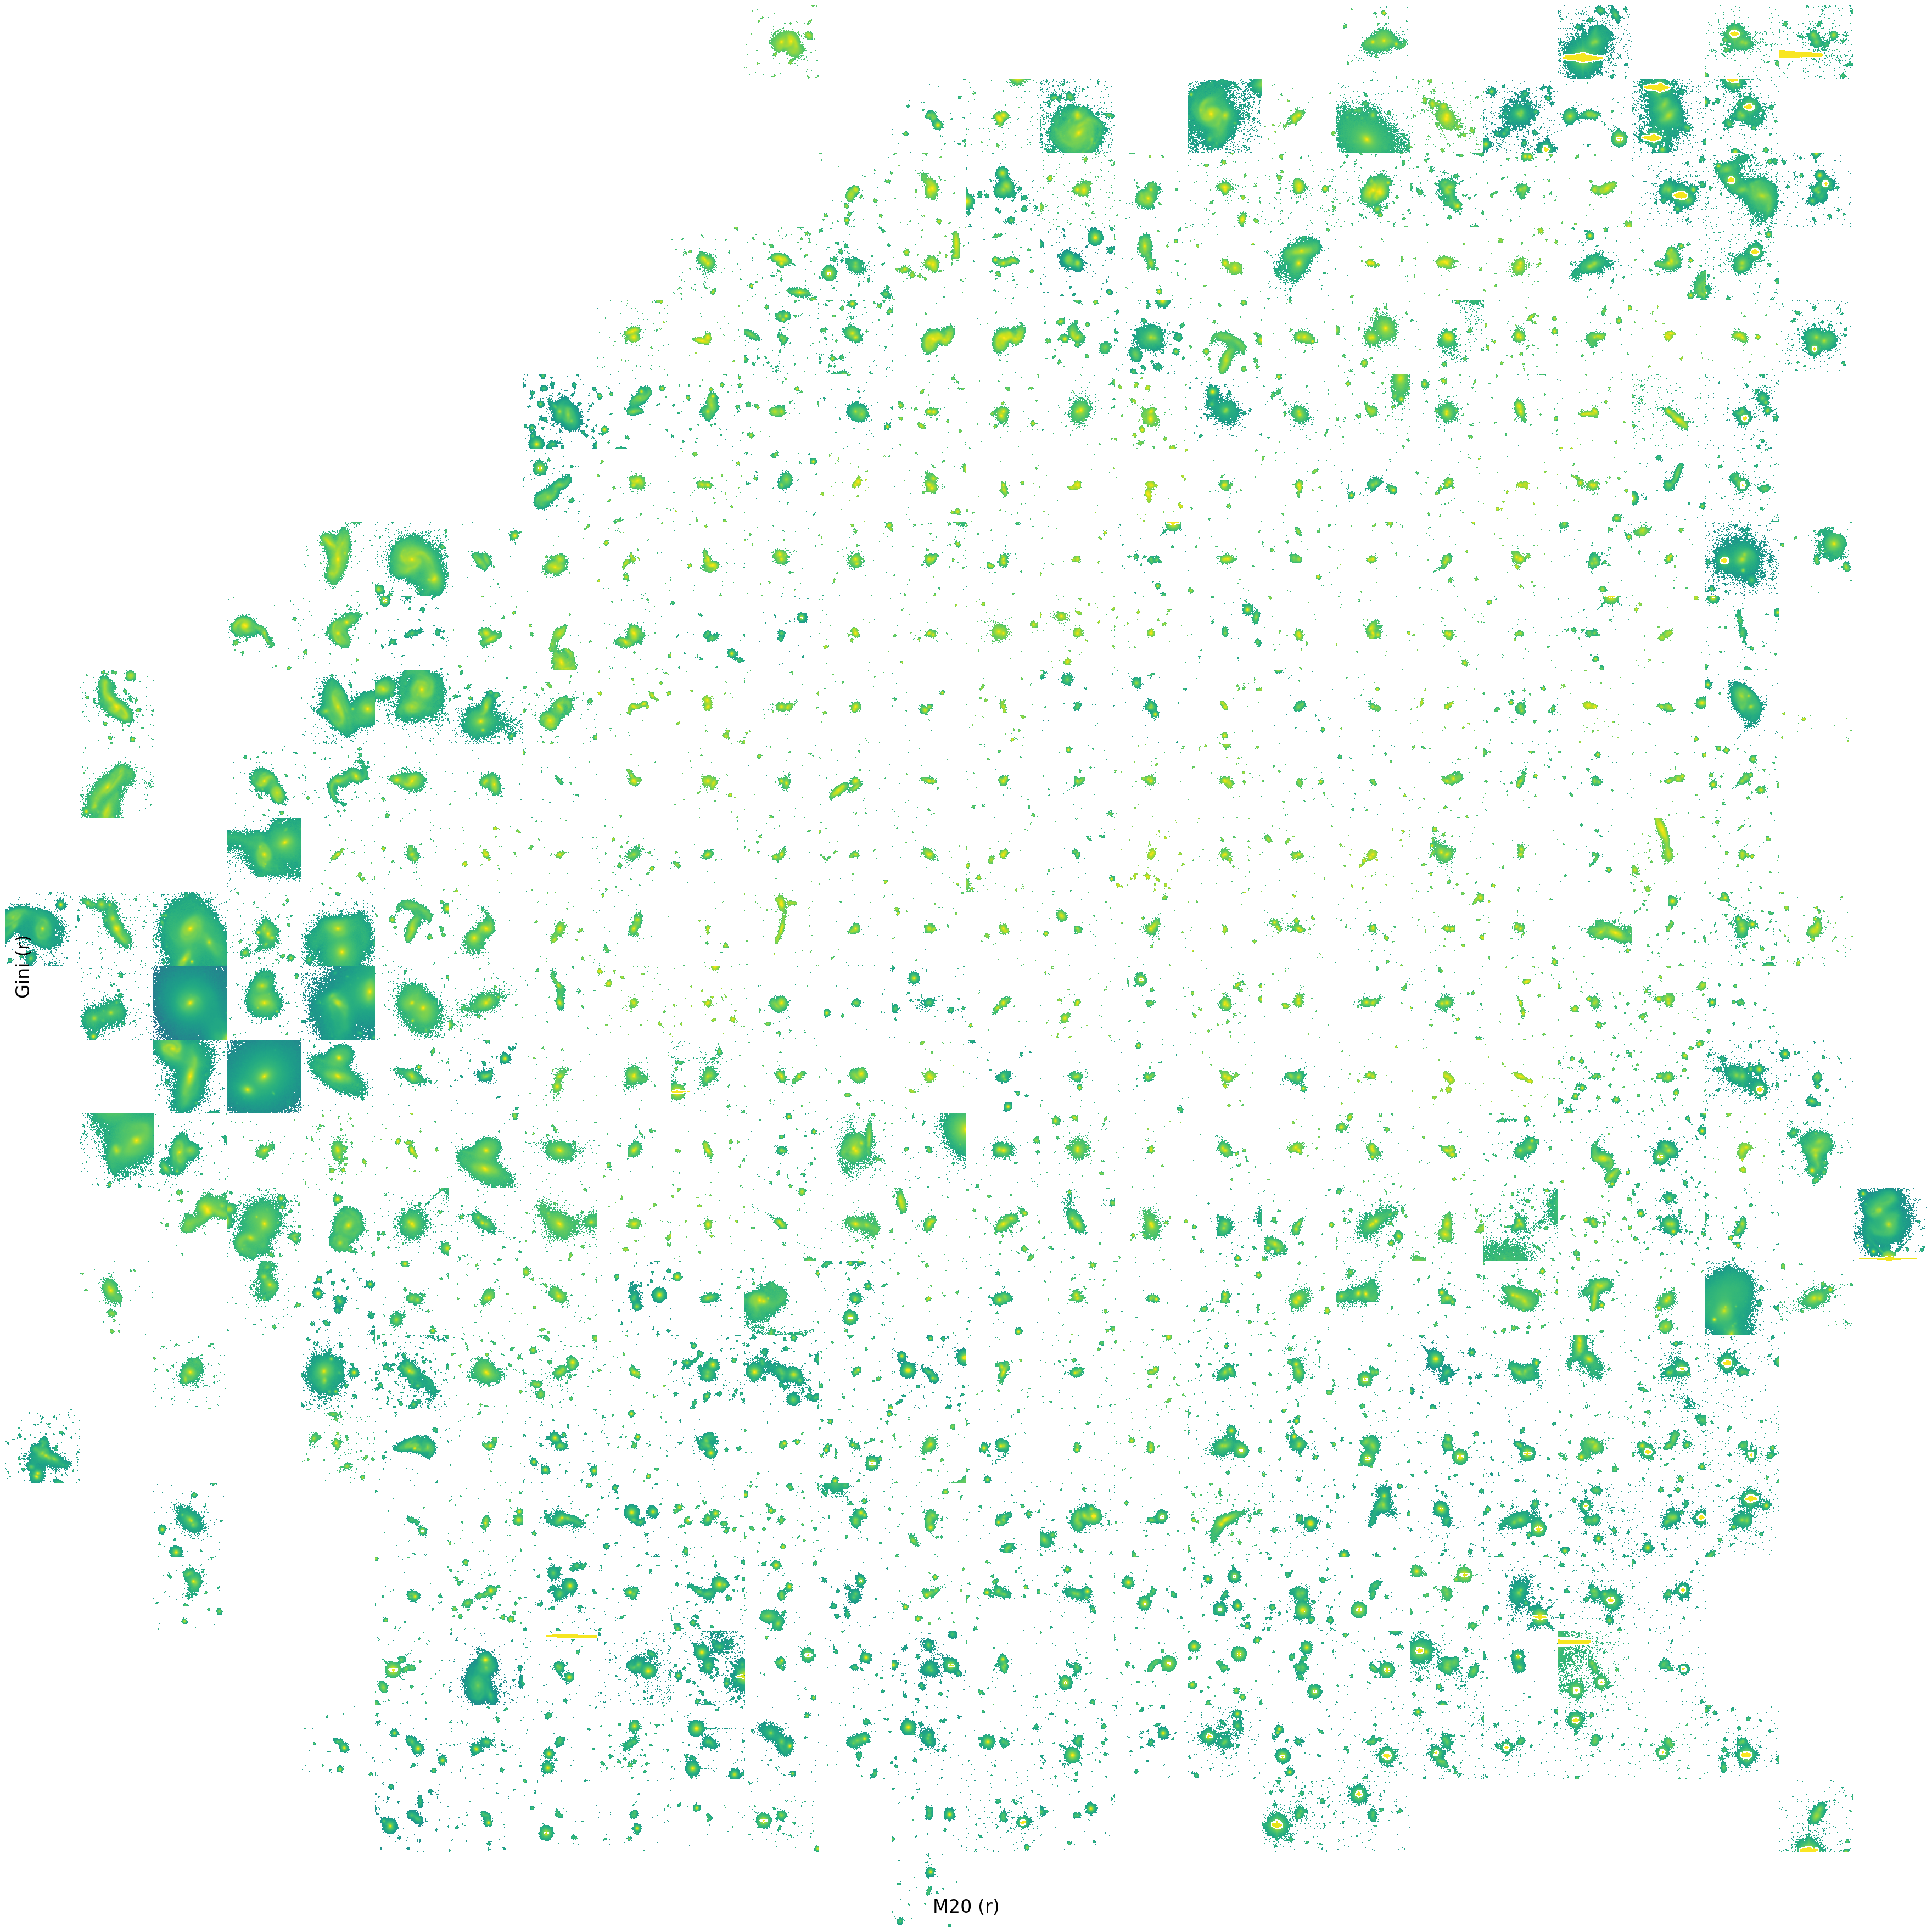

In [55]:
%%time
show_thumbnails(df_digi, num_bins = 25)

In [33]:
df_float.head()

id_str          ra        dec  est_petro_th50  \
0   390393_113  315.670729  10.126369        1.892756   
1  388975_4015  315.879343  10.010424        1.708224   
2  388975_4016  315.878811  10.011117        1.472603   
3  388976_4771  316.075869  10.014121        1.637970   
4  390397_3464  316.671962  10.263765        1.599376   

                                            hec_path              gini_r  \
0  /mmfs1/scratch/hpc/60/oryan/desi-mergers/39039...  0.4367436270352671   
1  /mmfs1/scratch/hpc/60/oryan/desi-mergers/38897...  0.3845745950876895   
2  /mmfs1/scratch/hpc/60/oryan/desi-mergers/38897...  0.3066920528418564   
3  /mmfs1/scratch/hpc/60/oryan/desi-mergers/38897...  0.4818692189742922   
4  /mmfs1/scratch/hpc/60/oryan/desi-mergers/39039...  0.4162541711414267   

                   m20  gini_r_int   m20_int  
0   -1.508202026561167    0.436744 -1.508202  
1  -0.9805751651001892    0.384575 -0.980575  
2  -0.9372621144140422    0.306692 -0.937262  
3  -1.0385375424330132    0.481869 -1.038538  
4   -0.926733600105912    0.416254 -0.926734

### Controlling for Redshift

In [50]:
folder = 'E:/GZ-DESI/data'
df_int = pd.read_parquet(f'{folder}/2023-03-15-cats/definitive-merged-interesting-params.parquet', engine = 'pyarrow')

In [51]:
df_int.columns

Index(['id_str', 'merging_none_fraction', 'merging_minor-disturbance_fraction',
       'merging_major-disturbance_fraction', 'merging_merger_fraction',
       'category', 'ra', 'dec', 'log_l_ha', 'log_l_oiii', 'photo_z', 'spec_z',
       'redshift', 'redshift_nsa', 'total_sfr_avg', 'elpetro_mass', 'logMH',
       'elpetro_mass_log', 'log_m_bh', 'log_bolometric_l'],
      dtype='object')

In [52]:
df_red = df_int[['id_str', 'redshift']]
del df_int

In [53]:
df_red.redshift.max()

1.0

In [37]:
df_merge = df_float.merge(df_red, on = 'id_str', how = 'left')

In [38]:
df_merge.m20_int.min()

-inf

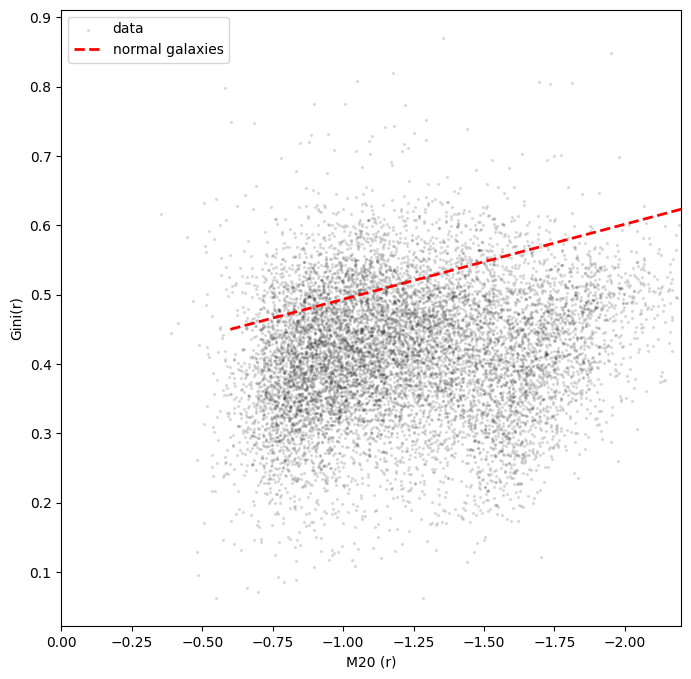

In [49]:
fig, ax1 = plt.subplots(nrows = 1)
df_merge.query('redshift < 0.075').plot.scatter(
    x = 'm20_int',
    y = 'gini_r_int',
    figsize = (8,8),
    s = 2,
    alpha = 0.1,
    color = 'black',
    xlim = [0, -2.2],
    ylabel = 'Gini(r)',
    xlabel = 'M20 (r)',
    ax = ax1,
    label = 'data'
)

ax1.plot(norm_arr[:,0], norm_arr[:,1], color = 'red', linestyle='dashed', linewidth = 2.0, label = 'normal galaxies')
plt.legend()

plt.show()